# MobileNetV2

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from imutils import paths
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
import psutil
import os


In [2]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

# Set dataset directory path
dataset_dir  = "E:/Hobby_Projects/MLOM/MobilenetV2/datasetlatest"

# # Print the total files in the dataset
# print("Total files in the dataset:", len(list(paths.list_images(dataset_dir))))

# List the subdirectories
subdirectories = ["forward", "left", "right", "stop"]

# Count files in each subdirectory
for subdir in subdirectories:
    subdir_path = os.path.join(dataset_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    print(f"Total files in {subdir}:", file_count)

Total files in forward: 350
Total files in left: 350
Total files in right: 350
Total files in stop: 350


In [3]:

# Get initial memory usage
initial_memory = psutil.virtual_memory().used / (1024 ** 2)  # in MB

In [5]:
# Load and preprocess images
image_paths = sorted(list(paths.list_images(dataset_dir)))
np.random.shuffle(image_paths)
data = []
labels = []

# New target size for images
target_size = (32, 32)

for image_path in image_paths:
    image = load_img(image_path, target_size=target_size)  # Resize images to (32, 24)
    image = img_to_array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert images from BGR to RGB
    image = preprocess_input(image)  # Normalize pixel values to [-1, 1]
    data.append(image)

    label = image_path.split(os.path.sep)[-2]
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)
print(f"{len(image_paths)} images ({data.nbytes / (1024 * 1000.0):.2f}MB)")
print("Data shape:", data.shape)


# # Load and preprocess images
# image_paths = sorted(list(paths.list_images(dataset_dir)))
# np.random.shuffle(image_paths)
# data = []
# labels = []

# for image_path in image_paths:
#     image = load_img(image_path, target_size=(32, 24))  # Resize images to (32, 24)
#     image = img_to_array(image)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert images from BGR to RGB
#     image = cv2.resize(image, (224, 224))  # Resize images to (224, 224)
#     image = preprocess_input(image)  # Normalize pixel values to [-1, 1]
#     data.append(image)

#     label = image_path.split(os.path.sep)[-2]
#     labels.append(label)

# data = np.array(data, dtype="float32")
# labels = np.array(labels)
# print(f"{len(image_paths)} images ({data.nbytes / (1024 * 1000.0):.2f}MB)")
# print("Data shape:", data.shape)

1400 images (16.80MB)
Data shape: (1400, 32, 32, 3)


In [7]:
# Print memory usage after loading images
memory_after_loading = psutil.virtual_memory().used / (1024 ** 2)  # in MB
print(f"Memory usage after loading images: {memory_after_loading:.2f} MB")


Memory usage after loading images: 6851.57 MB


In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Print class labels
print("Class labels:")
for (i, label) in enumerate(label_encoder.classes_):
    print(f"{i + 1}. {label}")

Class labels:
1. forward
2. left
3. right
4. stop


In [9]:
# Normalize labels to be in the range [0, num_classes-1]
labels = labels / (label_encoder.classes_.size - 1)

# Split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
print("Train set shape:", trainX.shape)
print("Test set shape:", testX.shape)

Train set shape: (1120, 32, 32, 3)
Test set shape: (280, 32, 32, 3)


In [10]:
# Define MobileNetV2 model
def MobileNetV2_model(input_shape, class_number):
    baseModel = MobileNetV2(
        include_top=False,
        input_tensor=Input(shape=input_shape),
    )

    for layer in baseModel.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(GlobalAveragePooling2D())  # Use GlobalAveragePooling2D instead of AveragePooling2D
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model


# # Define MobileNetV2 model
# def MobileNetV2_model(input_shape, class_number):
#     baseModel = MobileNetV2(
#         include_top=False,
#         input_tensor=Input(shape=input_shape),
#     )

#     for layer in baseModel.layers[:-4]:
#         layer.trainable = False

#     model = Sequential()
#     model.add(baseModel)
#     model.add(AveragePooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(512, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(class_number, activation='softmax'))

#     return model

In [11]:
# Set hyperparameters
shape = (32, 32, 3)  # Input shape for MobileNetV2 with 32 images and 3 color channels
epochs = 10
class_number = len(label_encoder.classes_)

In [12]:
# Create and compile the model
model = MobileNetV2_model(shape, class_number)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [13]:
# Define a callback to collect the training history
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))

history = LossHistory()

In [14]:
# Train the model
history = model.fit(
    trainX, trainY,
    batch_size=32,
    epochs=epochs,
    verbose=1,
    validation_data=(testX, testY),
    callbacks=[history]
)

Epoch 1/10
35/35 [==============================] - 9s 111ms/step - loss: 0.1992 - accuracy: 0.4679 - val_loss: 0.8724 - val_accuracy: 0.4571
Epoch 2/10
35/35 [==============================] - 2s 50ms/step - loss: 0.0332 - accuracy: 0.4938 - val_loss: 0.7276 - val_accuracy: 0.4821
Epoch 3/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0194 - accuracy: 0.4973 - val_loss: 0.6609 - val_accuracy: 0.4821
Epoch 4/10
35/35 [==============================] - 2s 48ms/step - loss: 0.0621 - accuracy: 0.4938 - val_loss: 0.5668 - val_accuracy: 0.4821
Epoch 5/10
35/35 [==============================] - 2s 48ms/step - loss: 0.0315 - accuracy: 0.4964 - val_loss: 0.5594 - val_accuracy: 0.4750
Epoch 6/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0010 - accuracy: 0.5000 - val_loss: 0.5364 - val_accuracy: 0.4821
Epoch 7/10
35/35 [==============================] - 2s 51ms/step - loss: 0.0106 - accuracy: 0.4982 - val_loss: 0.5434 - val_accuracy: 0.4821
Epoch 8/10
3

In [15]:
# Get memory usage after training
memory_after_training = psutil.virtual_memory().used / (1024 ** 2)  # in MB
print(f"Memory usage after training: {memory_after_training:.2f} MB")


Memory usage after training: 7021.66 MB


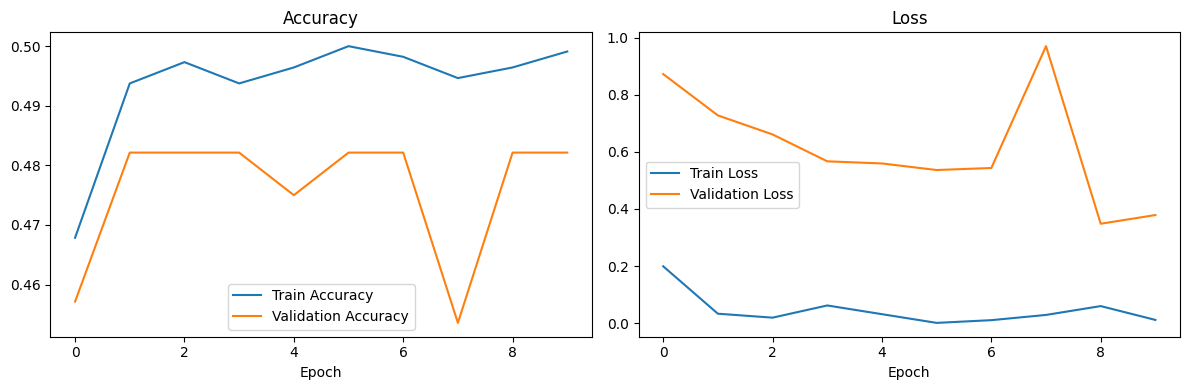

In [16]:
# Save the trained model
model.save('model.h5')

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Print memory usage after entire script execution
final_memory = psutil.virtual_memory().used / (1024 ** 2)  # in MB
print(f"Memory usage at the end of script: {final_memory:.2f} MB")

Memory usage at the end of script: 7071.87 MB


In [17]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable default optimizations
converter.target_spec.supported_types = [tf.float16]  # Use float16 data type for weights
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\darsh\AppData\Local\Temp\tmpy6tb9veh\assets


INFO:tensorflow:Assets written to: C:\Users\darsh\AppData\Local\Temp\tmpy6tb9veh\assets


In [66]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\darsh\AppData\Local\Temp\tmp5nyqk4g1\assets


INFO:tensorflow:Assets written to: C:\Users\darsh\AppData\Local\Temp\tmp5nyqk4g1\assets


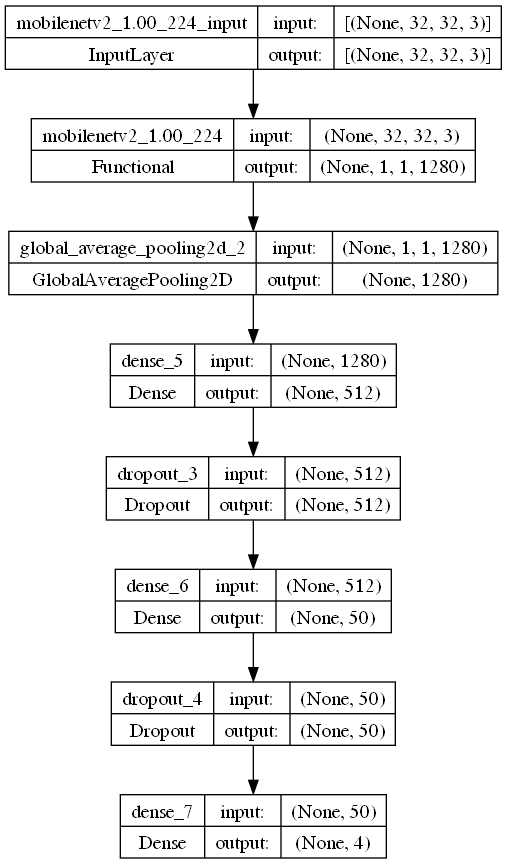

In [40]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Load the MobileNetV2 model
baseModel = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(32, 32, 3))  # Change input shape

# Create the complete model
model = tf.keras.Sequential()
model.add(baseModel)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


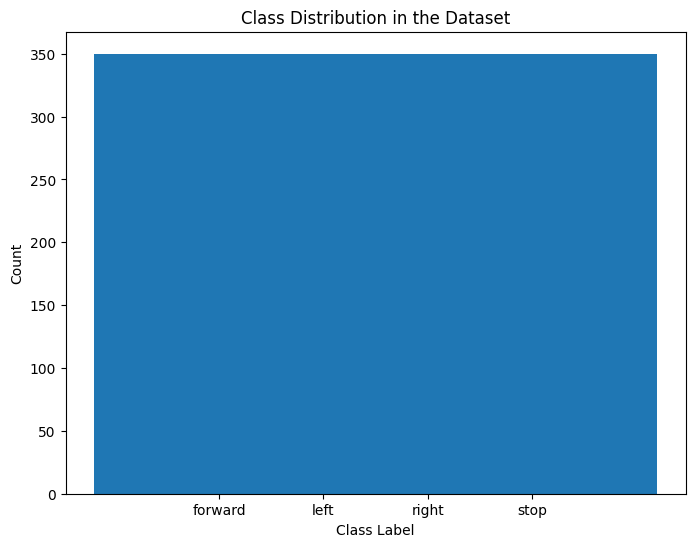

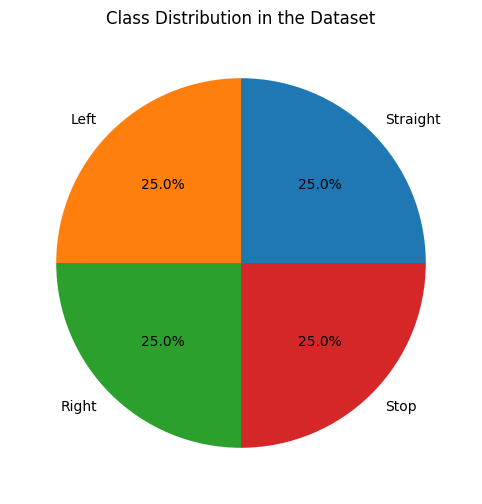

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset and preprocess it (you can use the code you provided)
dataset_dir  = "E:/Hobby_Projects/MLOM/MobilenetV2/datasetlatest"

# Count the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a bar chart to visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in the Dataset')
plt.xticks(unique_labels, ['forward', 'left', 'right', 'stop'])  # Update with your class labels
plt.show()

# Create a pie chart to visualize class distribution
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=['Straight', 'Left', 'Right', 'Stop'], autopct='%1.1f%%')
plt.title('Class Distribution in the Dataset')
plt.show()


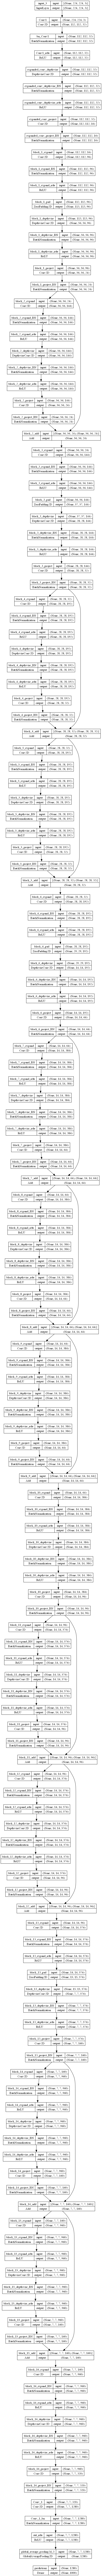

In [41]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Load the MobileNetV2 model
model = tf.keras.applications.MobileNetV2()

# Visualize the model
plot_model(model, to_file='mobilenetv2.png', show_shapes=True)
